In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import os
import tarfile
import pandas as pd
keras.backend.set_image_data_format('channels_last')

C:\Users\Soham\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Soham\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Soham\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Soham\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
ATTRS_NAME = "lfw_attributes.txt"
IMAGES_NAME = "lfw-deepfunneled.tgz" 

In [32]:
f=open(ATTRS_NAME,'r')
f.readline()

'# LFW Attribute Values v1.2 - lfw_attributes.txt - http://www.cs.columbia.edu/CAVE/projects/faceverification\n'

In [33]:
attr=[]
for x in f:
    attr.append(x.split('\t'))

In [34]:
columns=attr[0][1:]
attr=attr[1:]

In [35]:
images_with_attr=[]
for i in range(len(attr)):
    images_with_attr.append((attr[i][0],attr[i][1]))

In [36]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [37]:
all_photos = []
new_attr = []
with tarfile.open(IMAGES_NAME) as f:
    for m in f.getmembers():
        if m.isfile() and m.name.endswith(".jpg"):
            img = decode_image_from_raw_bytes(f.extractfile(m).read())
            img = img[80:-80, 80:-80]
            img = cv2.resize(img, (32, 32))
            fname = os.path.split(m.name)[-1]
            fname_splitted = fname[:-4].replace('_', ' ').split()
            person_id = ' '.join(fname_splitted[:-1])
            photo_number = str(int(fname_splitted[-1]))
            try:
                index=images_with_attr.index((person_id, photo_number))
                all_photos.append(img)
                new_attr.append(attr[index])
            except:
                pass

In [38]:
X=np.stack(all_photos).astype('float32')/255.0

In [39]:
len(X)

13143

In [40]:
X_train, X_test = train_test_split(X, test_size=0.25)

In [41]:
final_attr=pd.DataFrame(columns=columns,data=new_attr)

In [42]:
dic={}
for i in columns[1:]:
    dic[i]='float32'

In [43]:
final_attr=final_attr.astype(dic)

In [15]:
def build_encoder():
    encoder= keras.models.Sequential()
    encoder.add(L.InputLayer((32,32,3)))
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPool2D((2,2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPool2D((2,2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPool2D((2,2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPool2D((2,2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(32,activation='elu'))
#     encoder.summary()
    return encoder

In [16]:
def build_decoder():
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((32,)))
    decoder.add(L.Dense(1024,activation='elu'))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, padding='same'))
#     decoder.summary()
    return decoder

In [23]:
K.clear_session()

In [18]:
encoder=build_encoder()
decoder=build_decoder()
inp = L.Input((32,32,3))
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                421216    
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         421955    
Total params: 843,171
Trainable params: 843,171
Non-trainable params: 0
_________________________________________________________________


In [28]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test])

In [20]:
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [24]:
K.clear_session()

In [25]:
encoder=build_encoder()
decoder=build_decoder()
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")
inp = L.Input((32,32,3))
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                421216    
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         421955    
Total params: 843,171
Trainable params: 843,171
Non-trainable params: 0
_________________________________________________________________


In [26]:
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco)
    plt.show()

Convolutional autoencoder MSE: 0.004788077629680904


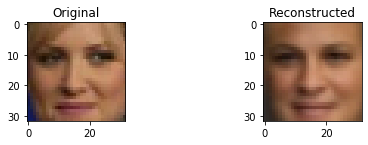

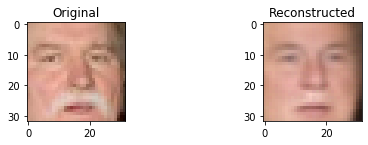

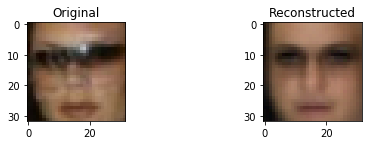

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


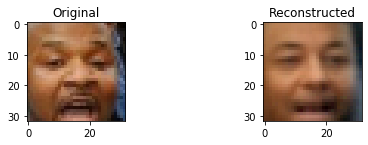

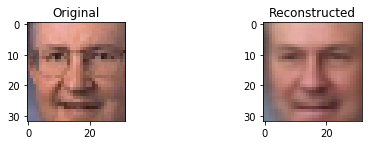

In [27]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [44]:
final_attr.head()

,person,imagenum,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace\n
0,AJ Cook,1.0,-2.104314,-2.049644,1.591600,-1.045685,-2.232376,-0.911712,0.613642,-0.781887,...,0.355319,-2.124374,0.262077,1.002586,-2.470392,0.393498,0.504409,0.256225,-0.676691,0.651946
1,AJ Lamas,1.0,0.061314,-1.203843,0.190530,-1.449692,-2.193837,-0.707221,0.424077,-0.337895,...,-0.645629,-0.689628,0.265310,-0.384761,0.291451,0.738267,0.841001,-0.060254,-0.637451,0.209275
2,Aaron Eckhart,1.0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.195580,-0.835609,-0.351468,...,0.361738,1.166118,-1.164916,-1.139990,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
3,Aaron Guiel,1.0,0.169851,-0.982408,0.422709,-1.282184,-1.360060,-0.867002,-0.452293,-0.197521,...,-0.832036,-0.397680,0.874160,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.666760,-0.496559
4,Aaron Patterson,1.0,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231


In [62]:
smiling=np.array(final_attr['Smiling'].nlargest(25).index)
sunglasses=np.array(final_attr['Sunglasses'].nlargest(25).index)

In [63]:
not_smiling=np.array(final_attr['Smiling'].nsmallest(25).index)
not_sunglasses=np.array(final_attr['Sunglasses'].nsmallest(25).index)

In [65]:
def findex(arr,indexes):
    new_arr=[]
    for i in indexes:
        new_arr.append(arr[i])
    return np.array(new_arr)

In [68]:
X_smiling=findex(X,smiling)
X_not_smiling=findex(X,not_smiling)
X_sunglasses=findex(X,sunglasses)
X_not_sunglasses=findex(X,not_sunglasses)

In [75]:
encode_smiling=np.mean(encoder.predict(X_smiling),0)-np.mean(encoder.predict(X_not_smiling),0)
encode_sunglasses=np.mean(encoder.predict(X_sunglasses),0)-np.mean(encoder.predict(X_not_sunglasses),0)

In [100]:
def add_feature(img,encode):
    code=encoder.predict(img[None])+encode
    reco=decoder.predict(code)[0]
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


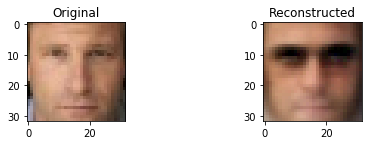

In [102]:
add_feature(X[2],encode_sunglasses)